In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString, box
import osmnx as ox
import networkx as nx
import folium
import matplotlib.pyplot as plt
import contextily as ctx
"""
This script performs the following tasks:

1. Imports necessary libraries including pandas, geopandas, shapely, osmnx, networkx, folium, and matplotlib.
2. Loads forest plot data from a CSV file.
3. Filters the data to include only plots in Alabama with specific criteria.
4. Converts latitude and longitude to Point objects and creates a GeoDataFrame.
5. Plots the forest GeoDataFrame.
6. Loads spatial boundary data for states and metropolitan statistical areas (MSAs).
7. Projects the MSA GeoDataFrame to a specified coordinate reference system (CRS).
8. Calculates the centroid of the MSA and the distance from each forest plot to the MSA centroid.
9. Sorts the forest plots by distance to the MSA and converts the distance to miles.
10. Plots the MSA boundary, forest plots, and lines connecting each forest plot to the MSA centroid.
11. Adds a basemap and sets the zoom level to the bounding box of the MSA plus a buffer.
12. Creates a bounding box polygon that encompasses both the forest plots and the MSA.
13. Downloads the road network within the bounding box using osmnx.
14. measure the distance between the centroid of the MSA and each forest plot
15. calculate the average distance between the MSA centroid and the forest plots.
16. calculate the driving time between the MSA centroid and each forest plot using the road network.

Variables:
- `forest_df`: DataFrame containing forest plot data.
- `forest_gdf`: GeoDataFrame containing forest plot data with geometry.
- `msa_gdf`: GeoDataFrame containing MSA boundary data.
- `msa_centroid`: Centroid of the MSA.
- `bbox_gdf`: GeoDataFrame containing the bounding box polygon.
- `G`: Road network graph within the bounding box.

Functions:
- None

Dependencies:
- pandas
- geopandas
- shapely
- osmnx
- networkx
- folium
- matplotlib
- contextily
"""

'\nThis script performs the following tasks:\n\n1. Imports necessary libraries including pandas, geopandas, shapely, osmnx, networkx, folium, and matplotlib.\n2. Loads forest plot data from a CSV file.\n3. Filters the data to include only plots in Alabama with specific criteria.\n4. Converts latitude and longitude to Point objects and creates a GeoDataFrame.\n5. Plots the forest GeoDataFrame.\n6. Loads spatial boundary data for states and metropolitan statistical areas (MSAs).\n7. Projects the MSA GeoDataFrame to a specified coordinate reference system (CRS).\n8. Calculates the centroid of the MSA and the distance from each forest plot to the MSA centroid.\n9. Sorts the forest plots by distance to the MSA and converts the distance to miles.\n10. Plots the MSA boundary, forest plots, and lines connecting each forest plot to the MSA centroid.\n11. Adds a basemap and sets the zoom level to the bounding box of the MSA plus a buffer.\n12. Creates a bounding box polygon that encompasses both

In [2]:
# Load the forest plot data
forest_df = pd.read_csv('data/FIA_2023_PLOT_US_MOG.csv')

# old growth only
# Filter data for Alabama with specific criteria
forest_df = forest_df[
    (forest_df['LOCATION_NM'] == 'Alabama') &
    (forest_df['MOG'] == 2) &
    (forest_df['OWNGRPCD'] != 40)
]


In [3]:
# Create a GeoDataFrame with geometry from latitude and longitude
forest_gdf = gpd.GeoDataFrame(
    forest_df,
    geometry=gpd.points_from_xy(forest_df['LON'], forest_df['LAT']),
    crs='EPSG:4326'
)
forest_gdf.plot()
plt.title('Forest Plots in Alabama')
plt.show()

In [139]:
boundaryPath = '/Users/mihiarc/Work/data/spatial-boundaries/'
states = gpd.read_file(f'{boundaryPath}tl_2023_us_state/tl_2023_us_state.shp')
msa = gpd.read_file(f'{boundaryPath}tl_2020_us_cbsa/tl_2020_us_cbsa.shp')

# Filter for the Birmingham-Hoover MSA
msa_gdf = msa[msa['NAME'].str.contains('Birmingham-Hoover, AL')]

# Project the MSA boundary to a UTM CRS
projected_crs = 'EPSG:32616'  # UTM zone for Alabama
forest_gdf = forest_gdf.to_crs(projected_crs)
msa_gdf = msa_gdf.to_crs(projected_crs)

In [141]:
# Get the centroid of the MSA
msa_centroid = msa_gdf.geometry.centroid.iloc[0]

# Calculate the distance between the centroid and each forest plot
forest_gdf['distance_to_msa'] = forest_gdf.geometry.distance(msa_centroid)

# Convert distance to miles
forest_gdf['distance_to_msa_miles'] = forest_gdf['distance_to_msa'] / 1609.34

# Print the average straight-line distance
print(f"The average straight-line distance: {forest_gdf['distance_to_msa_miles'].mean():.2f} miles")

The average straight-line distance: 86.08 miles


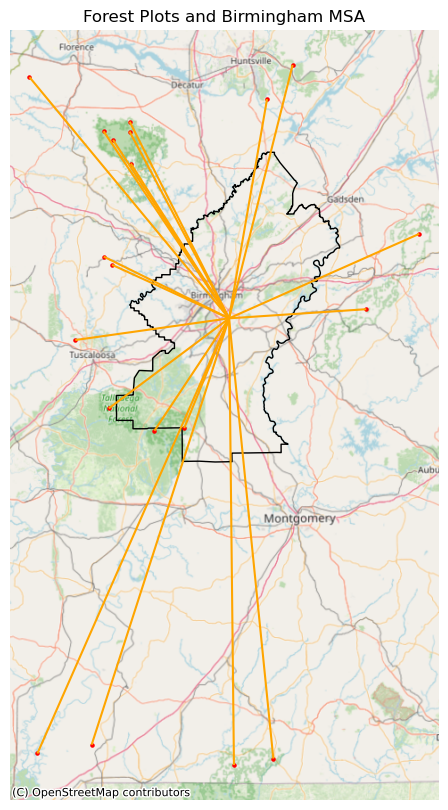

In [142]:
# Plot MSA boundary and forest plots
fig, ax = plt.subplots(figsize=(10, 10))
msa_gdf.plot(ax=ax, facecolor='none', edgecolor='black')
forest_gdf.plot(ax=ax, color='red', markersize=5)

# Plot lines connecting each forest plot to the MSA centroid
for idx, row in forest_gdf.iterrows():
    line = LineString([msa_centroid, row.geometry])
    gpd.GeoSeries([line], crs=projected_crs).plot(ax=ax, color='orange')

# Add basemap
ctx.add_basemap(ax, crs=forest_gdf.crs, source=ctx.providers.OpenStreetMap.Mapnik)

# Set the plot title and axis off
ax.set_title('Forest Plots and Birmingham MSA')
ax.set_axis_off()
plt.show()

In [143]:
# Reproject forest_gdf and msa_gdf back to WGS84 for OSMNX
forest_gdf_latlon = forest_gdf.to_crs('EPSG:4326')
msa_gdf_latlon = msa_gdf.to_crs('EPSG:4326')

# Get total bounds
xmin_forest, ymin_forest, xmax_forest, ymax_forest = forest_gdf_latlon.total_bounds
xmin_msa, ymin_msa, xmax_msa, ymax_msa = msa_gdf_latlon.total_bounds

# Determine the bounding box coordinates
south = min(ymin_forest, ymin_msa)
north = max(ymax_forest, ymax_msa)
west = min(xmin_forest, xmin_msa)
east = max(xmax_forest, xmax_msa)
# Download the road network within the bounding box
G = ox.graph_from_bbox(
    north=north,
    south=south,
    east=east,
    west=west,
    network_type='drive'
)

# Add edge speeds and travel times
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)
# Get MSA centroid in WGS84
msa_centroid_latlon = msa_centroid
msa_centroid_point = (msa_centroid_latlon.y, msa_centroid_latlon.x)

# Find the nearest node to the MSA centroid
msa_centroid_node = ox.nearest_nodes(G, X=msa_centroid_latlon.x, Y=msa_centroid_latlon.y)

# Initialize lists to store travel times and distances
travel_times = []
travel_distances = []

# Iterate over each forest plot
for idx, row in forest_gdf_latlon.iterrows():
    # Get the plot coordinates
    plot_point = row.geometry
    plot_x, plot_y = plot_point.x, plot_point.y

    # Find the nearest node to the forest plot
    plot_node = ox.nearest_nodes(G, X=plot_x, Y=plot_y)

    try:
        # Compute shortest travel time
        travel_time = nx.shortest_path_length(
            G, 
            source=msa_centroid_node, 
            target=plot_node, 
            weight='travel_time'
        )
        # Compute shortest travel distance
        travel_distance = nx.shortest_path_length(
            G, 
            source=msa_centroid_node, 
            target=plot_node, 
            weight='length'
        )
    except nx.NetworkXNoPath:
        # Handle cases where no path is found
        travel_time = None
        travel_distance = None

    # Append results
    travel_times.append(travel_time)
    travel_distances.append(travel_distance)

# Add results to the GeoDataFrame
forest_gdf['travel_time_sec'] = travel_times
forest_gdf['travel_distance_m'] = travel_distances
# Filter out None values
valid_travel_times = forest_gdf['travel_time_sec'].dropna()

# Convert travel time from seconds to minutes
forest_gdf['travel_time_min'] = forest_gdf['travel_time_sec'] / 60

# Calculate the average driving time
average_travel_time_min = forest_gdf['travel_time_min'].mean()
print(f"The average driving time: {average_travel_time_min:.2f} minutes")

<Figure size 640x480 with 0 Axes>

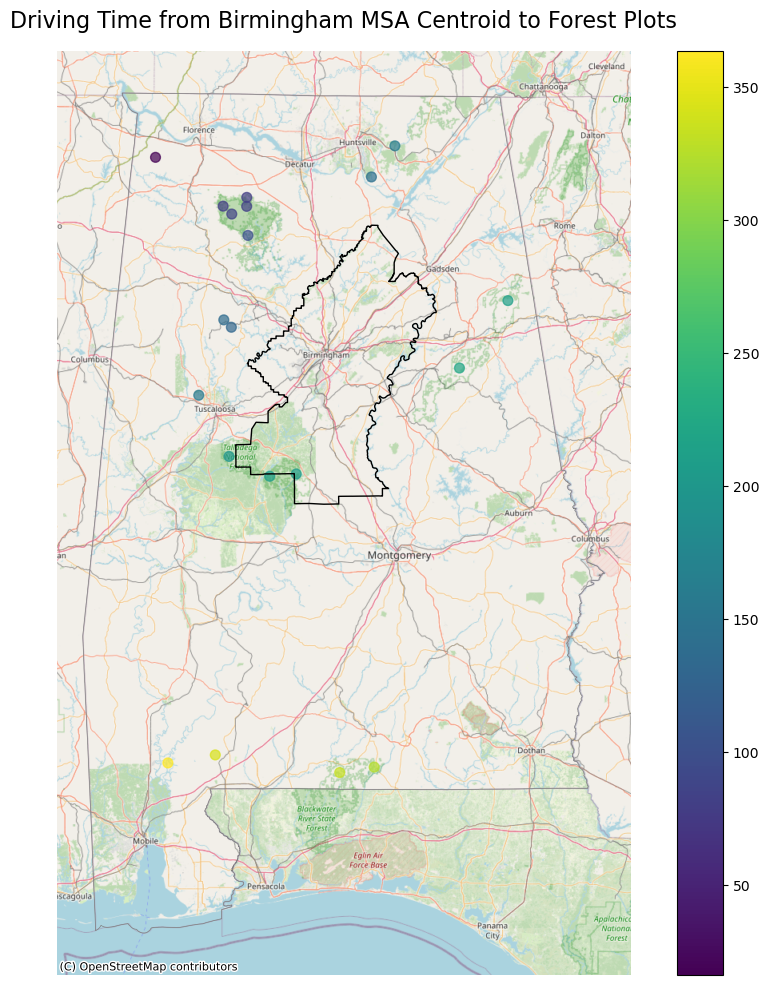

In [149]:
import matplotlib.pyplot as plt
import contextily as ctx

# Filter for Alabama
alabama = states[states['NAME'] == 'Alabama']
alabama = alabama.to_crs(projected_crs)

# Add Alabama boundary to the plot
alabama.boundary.plot(ax=ax, color='black')

# Reproject GeoDataFrames to Web Mercator (EPSG:3857) for plotting
forest_gdf_web = forest_gdf.to_crs(epsg=3857)
msa_gdf_web = msa_gdf.to_crs(epsg=3857)
alabama_web = alabama.to_crs(epsg=3857)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 12))

# Plot Alabama boundary
alabama_web.boundary.plot(ax=ax, color='grey', linewidth=0.5)

# Plot MSA boundary
msa_gdf_web.boundary.plot(ax=ax, edgecolor='black', linewidth=1)

# Plot forest plots, color-coded by travel time
# Handle cases where travel_time_min is None
forest_gdf_web = forest_gdf_web[forest_gdf_web['travel_time_min'].notnull()]

# Plot the forest plots
forest_gdf_web.plot(
    ax=ax,
    column='travel_time_min',
    cmap='viridis',
    legend=True,
    markersize=50,
    alpha=0.7
)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Set plot title and remove axes
ax.set_title('Driving Time from Birmingham MSA Centroid to Forest Plots', fontsize=16)
ax.set_axis_off()

# Show the plot
plt.show()

In [155]:
import folium
from folium.features import GeoJsonTooltip
from pyproj import Transformer

# Define the projected CRS used in your GeoDataFrames
projected_crs = msa_gdf.crs  # Should be 'EPSG:32616' as defined earlier

# Convert GeoDataFrames to WGS84 (EPSG:4326) for Folium
forest_gdf_latlon = forest_gdf.to_crs('EPSG:4326')
msa_gdf_latlon = msa_gdf.to_crs('EPSG:4326')

# Transform 'msa_centroid' to WGS84
transformer = Transformer.from_crs(projected_crs, 'EPSG:4326', always_xy=True)
msa_centroid_x, msa_centroid_y = transformer.transform(msa_centroid.x, msa_centroid.y)

# Initialize Folium map centered on the MSA centroid
m = folium.Map(location=[msa_centroid_y, msa_centroid_x], zoom_start=8)

# Add MSA boundary to the map
msa_geojson = folium.GeoJson(
    msa_gdf_latlon,
    name='MSA Boundary',
    style_function=lambda x: {'color': 'black', 'fill': False, 'weight': 2},
    tooltip=GeoJsonTooltip(fields=['NAME'], aliases=['MSA:'])
)
msa_geojson.add_to(m)

# Define color scale based on travel time
def get_color(travel_time):
    if travel_time is None:
        return 'gray'
    elif travel_time < 60:
        return 'green'
    elif travel_time < 120:
        return 'orange'
    else:
        return 'red'

# Ensure 'travel_time_min' and 'travel_distance_m' exist
if 'travel_time_min' not in forest_gdf_latlon.columns:
    print("Error: 'travel_time_min' column not found in 'forest_gdf_latlon'")
if 'travel_distance_m' not in forest_gdf_latlon.columns:
    print("Error: 'travel_distance_m' column not found in 'forest_gdf_latlon'")

# Add forest plots to the map
for idx, row in forest_gdf_latlon.iterrows():
    travel_time = row.get('travel_time_min')
    travel_distance = row.get('travel_distance_m')
    # Use 'PLT_CN' as the Plot ID
    plot_id = row.get('PLT_CN', idx)
    if travel_time is not None:
        popup_text = f"""
        <strong>Travel Time:</strong> {travel_time:.2f} minutes<br>
        <strong>Travel Distance:</strong> {travel_distance/1000:.2f} km<br>
        <strong>Plot ID:</strong> {plot_id}
        """
    else:
        popup_text = f"""
        <strong>Travel Time:</strong> Not Available<br>
        <strong>Plot ID:</strong> {plot_id}
        """
    # Check if geometry exists and is valid
    if row.geometry and not row.geometry.is_empty:
        # Add the forest plot as a CircleMarker
        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=5,
            popup=folium.Popup(popup_text, max_width=300),
            color=get_color(travel_time),
            fill=True,
            fill_color=get_color(travel_time),
            fill_opacity=0.7
        ).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

legend_html = '''
     <div style="position: fixed; 
                 bottom: 50px; left: 50px; width: 200px; height: 120px; 
                 border:2px solid grey; z-index:9999; font-size:14px;
                 background-color:white; padding: 10px;">
     <b>Travel Time Legend</b><br>
     <i class="fa fa-circle" style="color:green"></i>&nbsp; < 60 minutes<br>
     <i class="fa fa-circle" style="color:orange"></i>&nbsp; 60-120 minutes<br>
     <i class="fa fa-circle" style="color:red"></i>&nbsp; > 120 minutes<br>
     <i class="fa fa-circle" style="color:gray"></i>&nbsp; Not Available
     </div>
     '''
m.get_root().html.add_child(folium.Element(legend_html))

# Save the map to an HTML file
m.save('forest_plots_map.html')

# To display the map in a Jupyter Notebook (if applicable)
# from IPython.display import IFrame
# IFrame('forest_plots_map.html', width=800, height=600)